# Quantum Graph Convolutional Neural Network

adopted and adapted from https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

Development follows the structured CRISP-DM Process of Writh and Hipp (2000) 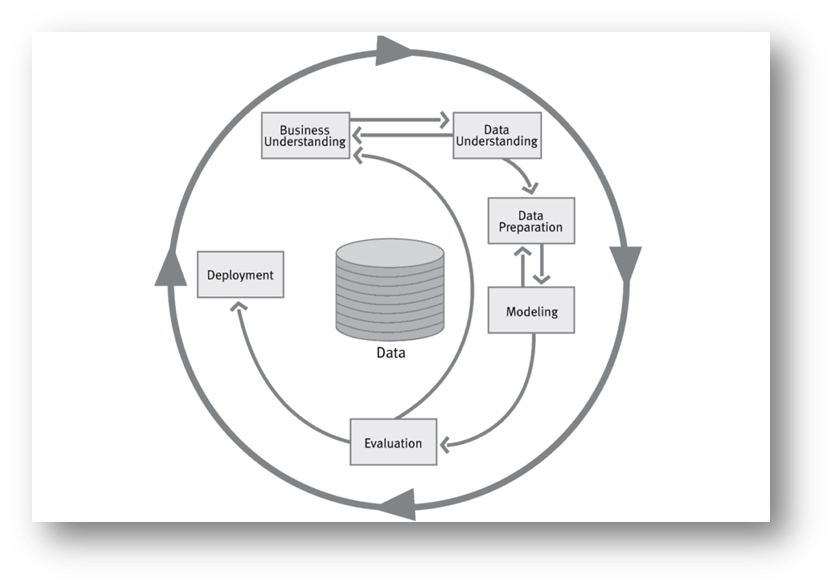

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
import numpy as np
from torch.utils.data import random_split
# import jax
import os
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

algorithm_globals.random_seed = 12345

# 2. Data Understanding & 3. Data Preparation

## Data Preprocessing

In [2]:
# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < 200:
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[3], labels[3])
print(len(features), len(labels))

[ 0.02860095  0.          0.43550962 -0.95333518  0.         -0.71874285
  0.49941735  0.         -0.36650326] [-76.24559204]
40 40


### label and feature transformation for better performance

In [3]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def convert_record(d):
    # elements
    e = d.z #.numpy()
    # xyz position
    x = d.pos.numpy() # das hier ist Numpy aber wird später zu tensor (bei x2e)
    # target 
    y = d.y[0][7]

    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 16))
    ohc[np.arange(len(e)), e - 1] = 1
    ohc_tensor = torch.from_numpy(ohc)
    return (ohc_tensor, x), y


features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

#train_ym = np.mean(ys)
#train_ys = np.std(ys)

#print("Mean = ", train_ym, "Std =", train_ys)


def transform_label(y):
    return (y - train_labelm) / train_labelstd


def transform_prediction(y):
    return y * train_labelstd + train_labelm

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])

test_size=0.25
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.75, random_state=algorithm_globals.random_seed
)


Mean =  -76.049059695275 Std = 0.1479334099080764
40
[-1.51982859]


In [4]:
def x2e(x):
    """convert xyz coordinates to inverse pairwise distance"""
    r2 = np.sum((x - x[:, np.newaxis, :]) ** 2, axis=-1)
    e = np.where(r2 != 0, 1 / r2, 0.0)
    e = torch.from_numpy(e).double()
    return e


# 4. Modeling


## Implementation of QGCN layers

### Definition of convolutional circuits of the QGCN

c:\Python\Python3.9.2\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


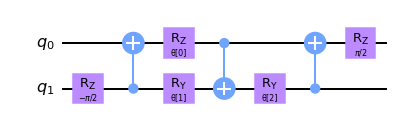

In [4]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

### Definition of convolutional layers of the QGCN

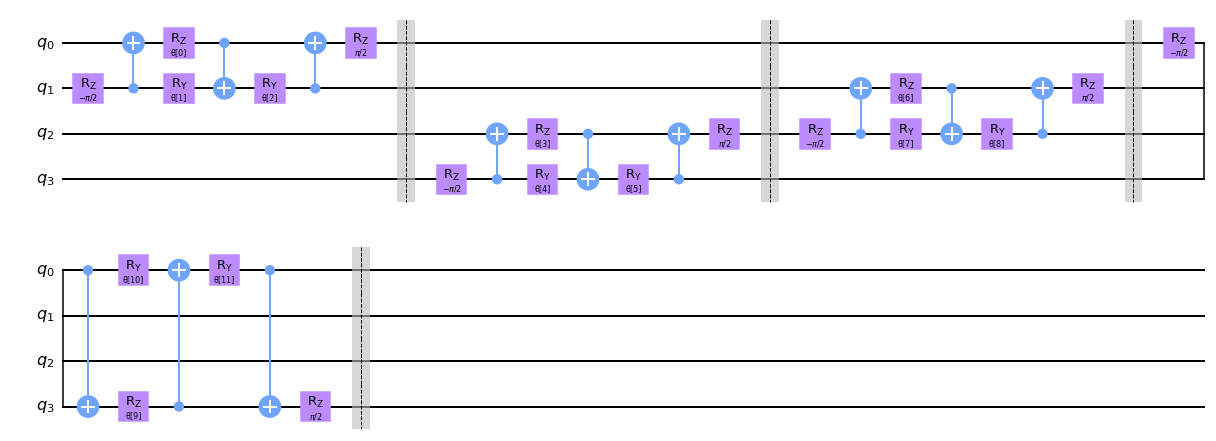

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

### Definition of pooling circuits of the QGCN

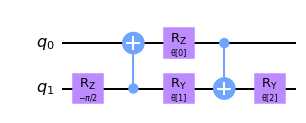

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

### Definition of pooling layers of the QGCN

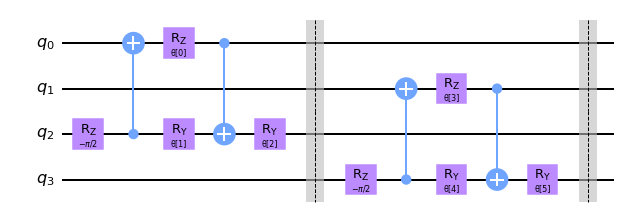

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

### data encoding using ZFeatureMap from Qiskit

In [127]:
feature_map = ZFeatureMap(9)

### Angle Encoding

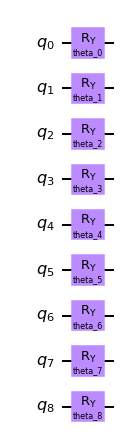

In [8]:
from qiskit.circuit import Parameter
# Create a list of 9 Parameter objects
parameters = [Parameter(f'theta_{i}') for i in range(9)]

# Create a quantum circuit with 9 qubits
feature_map = QuantumCircuit(9)

# Use parameters in Ry gates to encode data points
for i, param in enumerate(parameters):
    feature_map.ry(param, i)
    

    
feature_map.draw(output='mpl')

### Angle Encoding with coordinate relations

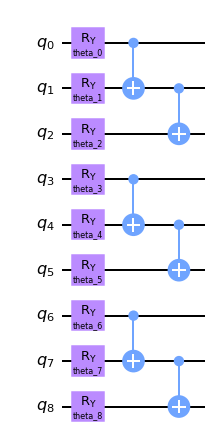

In [11]:

# Create a list of 9 Parameter objects
parameters = [Parameter(f'theta_{i}') for i in range(9)]

# Create a quantum circuit with 9 qubits
feature_map = QuantumCircuit(9)

# Use parameters in Ry gates to encode data points
for i, param in enumerate(parameters):
    feature_map.ry(param, i)

# Apply entangling gates within each group of three qubits
for i in range(0, 9, 3):
    feature_map.cx(i, i+1)
    feature_map.cx(i+1, i+2)

# At this point, the circuit is defined with parameters instead of fixed values.
# To visualize the circuit with parameters
feature_map.draw("mpl")

### Angle Encoding with coordinate relations and atom bondings

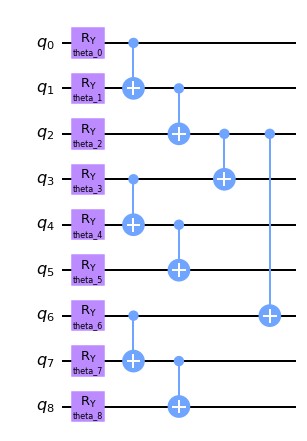

In [24]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# Create a list of 9 Parameter objects for the 9 qubits
feature_map = [Parameter(f'x{i}') for i in range(9)]

# Initialize the quantum circuit
feature_map = QuantumCircuit(9)

# Apply rotation gates with parameters to encode atom positions
for i, param in enumerate(parameters):
    feature_map.ry(param, i)
    

# Apply intra-group entanglement for each atom
for i in range(0, 9, 3):
    feature_map.cx(i, i+1)
    feature_map.cx(i+1, i+2)

feature_map.cx(2, 3)

feature_map.cx(2, 6)

feature_map.draw("mpl")

### Structuring of all layers of the QGCN

- composing of the QGCN ansatz using all previously defined circuits and layers 

SparsePauliOp(['ZIIIIIIII'],
              coeffs=[9.+0.j])


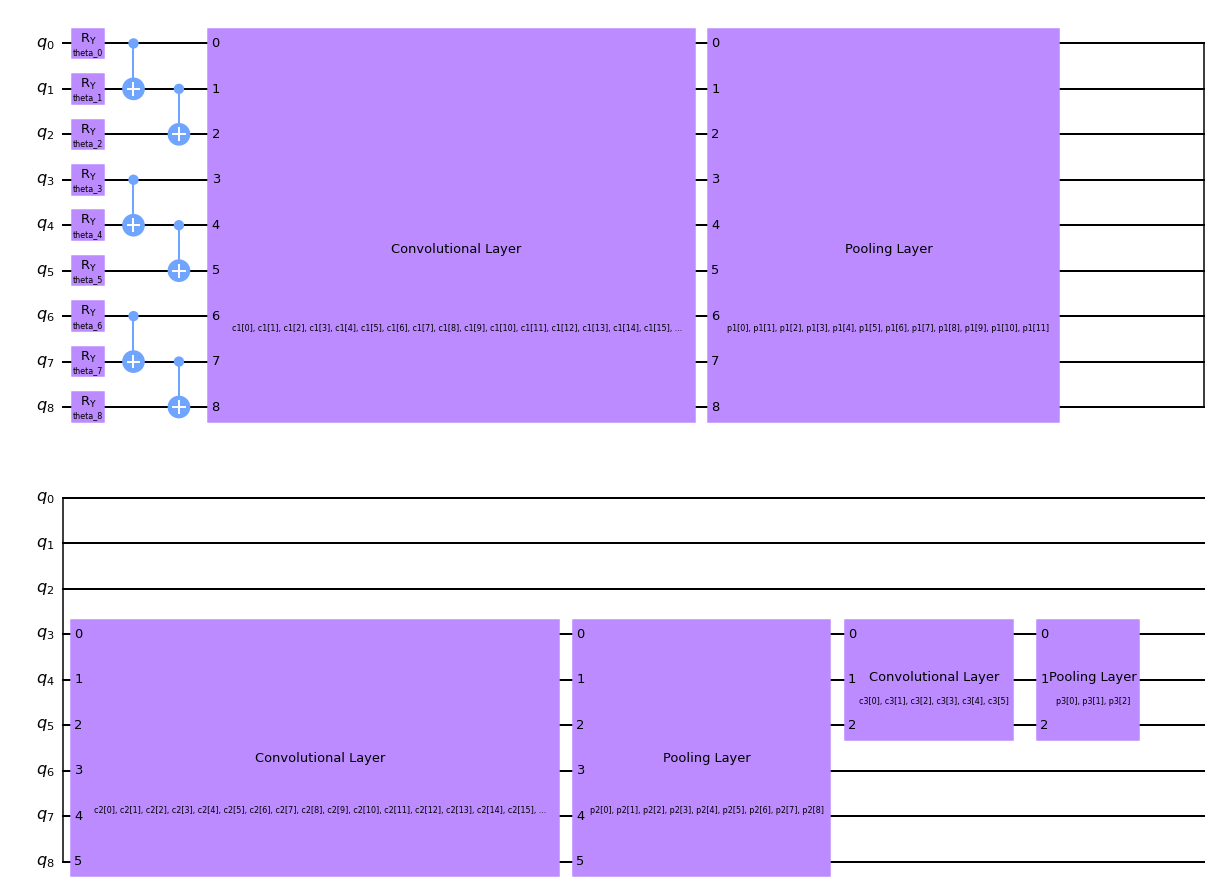

In [13]:

ansatz = QuantumCircuit(9, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(9, "с1"), list(range(9)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4], [5, 6, 7, 8], "p1"), list(range(9)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(6, "c2"), list(range(3, 9)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2], [2, 3, 4], "p2"), list(range(3, 9)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(3, "c3"), list(range(3, 6)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2], "p3"), list(range(3, 6)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(9)
circuit.compose(feature_map, range(9), inplace=True)
circuit.compose(ansatz, range(9), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 8, 9)])
print(observable)


# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl")


## Training of the model and obversable function

In [14]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
regressor = NeuralNetworkRegressor(
    qnn,
    loss="squared_error",
    optimizer=COBYLA(maxiter=250),
    callback=callback_graph,
)

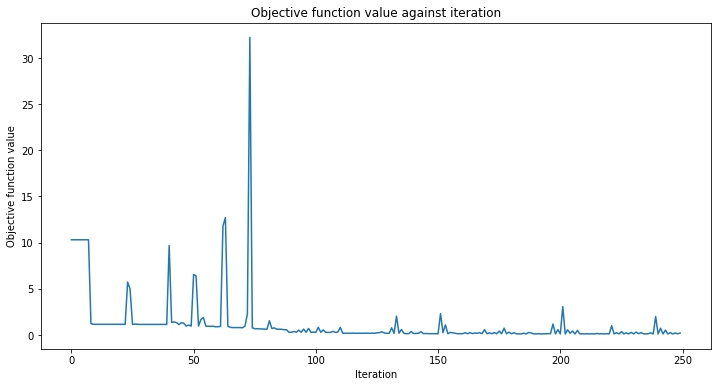

In [16]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
regressor.fit(train_features, train_labels)

# 5. Evaluation of the developed model

### evaluating the model using plots and relevant regression metrics

In [17]:
print(f"Accuracy from the train data : {np.round(100 * regressor.score(train_features, train_labels), 2)}%")

Accuracy from the train data : 87.26%


In [18]:
predictions = regressor.predict(test_features)

In [19]:
print(f"Accuracy from the test data : {np.round(100 * regressor.score(test_features, test_labels ), 2)}%")

Accuracy from the test data : 84.56%


RMSE: 0.06924129844406392
MSE: 0.23080233507925502
R-squared (R2) Score: 0.8455668134946793


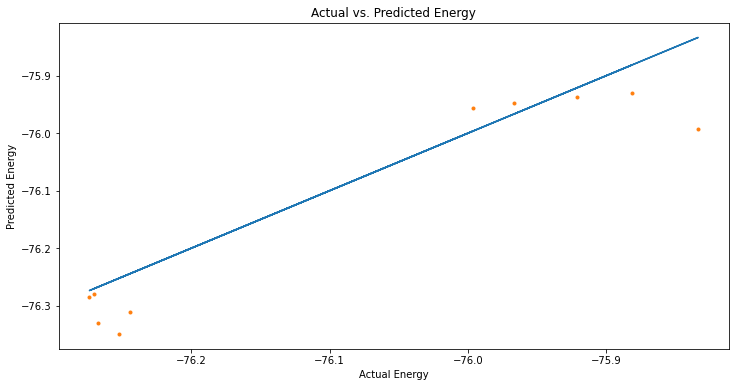

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Inverse transform the transformed labels
predictions  = (predictions * train_labelstd) + train_labelm
test_labels = (test_labels * train_labelstd) + train_labelm


rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'RMSE: {rmse}')

mse = np.sqrt(mean_absolute_error(test_labels, predictions))
print(f'MSE: {mse}')

r2 = r2_score(test_labels, predictions)
print("R-squared (R2) Score:", r2)


""" plt.scatter(test_labels, predictions) """
plt.plot(test_labels, test_labels, "-")
plt.plot(test_labels, predictions, ".")
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Actual vs. Predicted Energy')
plt.show()